# Weak Supervision (Gaussian Toy Example)

In this notebook, we will demonstrate the basics of weak supervision in the context of anomaly detection. 
We will use simple Gaussian toy data to demonstrate the basic concepts. 
For a similar demonstration on realistic physics data, see the `weak_supervision.ipynb` notebook.

The usual approach to find a powerful discriminant for distinguishing two classes of data (here signal and background) from each other, is to train a machine learning classifier (e.g. a neural network) to distinguish the classes from each other, based on some input features $x$. At each training iteration, we compare the output of the classifier $f(x)$ to the actual label $y$ (1 for signal, 0 for background) of the training data via the loss function (usually binary cross entropy) and optimize the weights of the classifier such that they match as well as possible. What the classifier learns then is to approximate the likelihood ratio $\frac{p_{sig}}{p_{bkg}}$, which is the most powerful test statistic according to the Neyman Pearson Lemma. This *fully supervised classifier* relies on knowing a-priori which training data are signal and which are background during training.

However, there might be cases where one does not have such truth labels in advance. This is often the case in anomaly detection where one searches for small hints of anomalous signal within an overwhelming background, without knowing ahead of time what the signal looks like. In this case we only have our measured data, that consists of background and maybe some signal. We do not know the true 'label' of any of these data events, so we cannot perform traditional supervised training.
In addition, we somehow got an extra sample of just background data. If that was the case, we could just train a classifier to distinguish these two classes (data=sig+bkg vs bkg). Our classifier would approach a likelihood ratio that is monotonically linked to the signal-vs-bkg one $\frac{p_{(sig+bkg)}}{p_{bkg}} = \frac{f_{sig} p_{sig} + (1- f_{sig}) p_{bkg}}{p_{bkg}} = f_{sig} \frac{p_{sig}}{p_{bkg}} + (1 - f_{sig})$ where $f_{sig}$ is the (unknown) signal fraction in the data.
This method of training is called weak supervision. 

A significant challenge in the application of this method is where to get the magic background-only sample. One might have a very good Monte Carlo simulation, or one might instead generate it in-situ via some data-driven estimate. The latter is the approach that multiple weak supervision methods take, such as [CWoLa Hunting](https://arxiv.org/abs/1902.02634), [SALAD](https://arxiv.org/abs/2212.10579), [CATHODE](https://arxiv.org/abs/2109.00546), [CURTAINS](https://arxiv.org/abs/2203.09470), [FETA](https://arxiv.org/abs/2212.11285). For now, we just assume we already have such a large background-only sample. We often refer to this idealization as the *idealized anomaly detector* (IAD).


In [1]:
import numpy as np
import scipy
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import copy
from os.path import exists, join, dirname, realpath


# adding parent directory to path
parent_dir = dirname(realpath(globals()["_dh"][0]))
sys.path.append(parent_dir)

from sk_cathode.classifier_models.neural_network_classifier import NeuralNetworkClassifier

First, lets define the data distributions we will be working with. 
Since we are generating the data ourselves we can pick its dimensionality, and how different the signal and background are.
For now lets keep it simple and work with two dimensional data, but feel free to come back and play around with this choice. 

In [2]:
#Pick the dimensionality of our dataset
n_dim = 2 #How many total dimensions of our data
n_signal_dim = 2 #How many dimensions of our signal are different from background


#Background is multi-dim Gaussian with zero mean, diagonal covariance of one
bkg_means = np.array([0.]*n_dim)
bkg_vars = np.ones(n_dim)
bkg_cov = np.diag(bkg_vars)
bkg_pdf = scipy.stats.multivariate_normal(bkg_means, bkg_cov)


#Signal is multi-dim Gaussian centered at 1 for 'signal like dimensions and 0 for the bkg-like dimensions
sig_means = np.array([1.0]*n_signal_dim + [0.] *(n_dim - n_signal_dim) )
sig_vars = np.array(n_signal_dim * [0.1] + [1.0]* (n_dim - n_signal_dim))
sig_cov = np.diag(sig_vars)
sig_pdf = scipy.stats.multivariate_normal(sig_means, sig_cov)

verbose = 0


In [3]:
#Data for training of supervised classifer
n_sup = 5000
sig_events_sup = sig_pdf.rvs(size = n_sup)
bkg_events_sup = bkg_pdf.rvs(size = n_sup)

x_sup = np.append(sig_events_sup, bkg_events_sup, axis = 0)
y_sup = np.append(np.ones(n_sup, dtype = np.int8), np.zeros(n_sup, dtype =np.int8))

x_sup, y_sup = shuffle(x_sup, y_sup, random_state = 42)
x_sup_train, x_sup_val, y_sup_train, y_sup_val = train_test_split(x_sup, y_sup, test_size = 0.2, random_state = 42)

#Data for testing
n_test = 50000
sig_events_test = sig_pdf.rvs(size = n_test//10)
bkg_events_test = bkg_pdf.rvs(size = n_test)

x_test = np.append(sig_events_test, bkg_events_test, axis = 0)
y_test = np.append(np.ones(n_test//10, dtype = np.int8), np.zeros(n_test, dtype =np.int8))



Lets plot our data to get a feel of how the distributions we defined look 

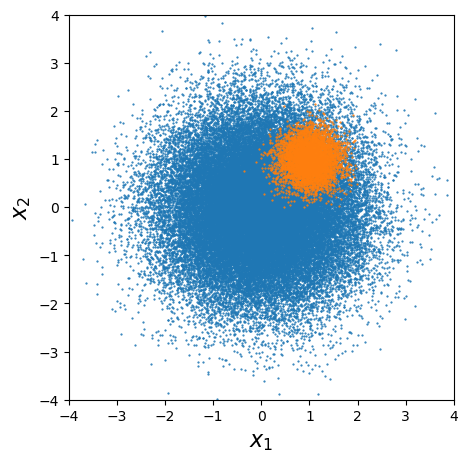

In [4]:
# Simple scatter plot of our data, background is in blue, signal is in orange
plt.figure(figsize = (5,5))
plt.scatter(bkg_events_test[:,0],bkg_events_test[:,1],s=0.3,color='C0')
plt.scatter(sig_events_test[:,0],sig_events_test[:,1],s=0.3,color='C1')
plt.gca().set_aspect(1.)
plt.xlabel(r'$x_1$',fontsize=16)
plt.ylabel(r'$x_2$',fontsize=16)
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.show()


Note that for this example, the signal is entirely contained within the distribution of the background.
So in this case, our anomaly is an overdensity of events within a particular region of phase space. 
This can easily occur for realistic particle physics examples in which backgrounds (such as QCD) are copious and populate a huge phase space. 
For many other fields, anomalies are always outliers, entirely outside the phase space of typical backgrounds. 
Methods which are built on the idea of finding outliers (eg autoencoders) may therefore struggle to find this type of anomaly. 

In [11]:
#Supervised model
#sup_model = get_model()
#sup_model_hist = sup_model.fit(x_sup, y_sup, epochs = n_epoch, batch_size = batch_size, 
#                validation_split = val_frac, callbacks = [early_stop], shuffle = True)
sup_model = NeuralNetworkClassifier(n_inputs=n_dim,
                                                   early_stopping=True, epochs=100,
                                                   verbose=True)
sup_model.fit(x_sup_train, y_sup_train, x_sup_val, y_sup_val)


Epoch: 0


Train loss: 0.469947: 100%|██████████| 8000/8000 [00:00<00:00, 17436.85it/s]


Validation loss: 0.23780536372214556

Epoch: 1


Train loss: 0.234326: 100%|██████████| 8000/8000 [00:00<00:00, 20295.39it/s]


Validation loss: 0.2079301392659545

Epoch: 2


Train loss: 0.220356: 100%|██████████| 8000/8000 [00:00<00:00, 18819.00it/s]


Validation loss: 0.20076708495616913

Epoch: 3


Train loss: 0.210410: 100%|██████████| 8000/8000 [00:00<00:00, 18700.86it/s]


Validation loss: 0.19667022116482258

Epoch: 4


Train loss: 0.208427: 100%|██████████| 8000/8000 [00:00<00:00, 23369.57it/s]


Validation loss: 0.19535081274807453

Epoch: 5


Train loss: 0.205406: 100%|██████████| 8000/8000 [00:00<00:00, 19513.54it/s]


Validation loss: 0.19496810995042324

Epoch: 6


Train loss: 0.204353: 100%|██████████| 8000/8000 [00:00<00:00, 19622.73it/s]


Validation loss: 0.19716043723747134

Epoch: 7


Train loss: 0.203232: 100%|██████████| 8000/8000 [00:00<00:00, 21046.52it/s]


Validation loss: 0.19421897735446692

Epoch: 8


Train loss: 0.204794: 100%|██████████| 8000/8000 [00:00<00:00, 19770.20it/s]


Validation loss: 0.19673251081258059

Epoch: 9


Train loss: 0.201545: 100%|██████████| 8000/8000 [00:00<00:00, 19927.74it/s]


Validation loss: 0.19597968831658363

Epoch: 10


Train loss: 0.202881: 100%|██████████| 8000/8000 [00:00<00:00, 19191.12it/s]


Validation loss: 0.19414707459509373

Epoch: 11


Train loss: 0.202467: 100%|██████████| 8000/8000 [00:00<00:00, 19615.10it/s]


Validation loss: 0.19393238332122564

Epoch: 12


Train loss: 0.201077: 100%|██████████| 8000/8000 [00:00<00:00, 18834.39it/s]


Validation loss: 0.197329415474087

Epoch: 13


Train loss: 0.203260: 100%|██████████| 8000/8000 [00:00<00:00, 18920.80it/s]


Validation loss: 0.1941060395911336

Epoch: 14


Train loss: 0.201550: 100%|██████████| 8000/8000 [00:00<00:00, 21132.20it/s]


Validation loss: 0.19561736192554235

Epoch: 15


Train loss: 0.202193: 100%|██████████| 8000/8000 [00:00<00:00, 19845.36it/s]


Validation loss: 0.1927920044399798

Epoch: 16


Train loss: 0.201903: 100%|██████████| 8000/8000 [00:00<00:00, 18123.36it/s]


Validation loss: 0.19914903119206429

Epoch: 17


Train loss: 0.201106: 100%|██████████| 8000/8000 [00:00<00:00, 18854.76it/s]


Validation loss: 0.19560841005295515

Epoch: 18


Train loss: 0.200404: 100%|██████████| 8000/8000 [00:00<00:00, 19191.75it/s]


Validation loss: 0.19694519601762295

Epoch: 19


Train loss: 0.201102: 100%|██████████| 8000/8000 [00:00<00:00, 20734.33it/s]


Validation loss: 0.1985676409676671

Epoch: 20


Train loss: 0.202507: 100%|██████████| 8000/8000 [00:00<00:00, 19385.55it/s]


Validation loss: 0.19796696491539478

Epoch: 21


Train loss: 0.199680: 100%|██████████| 8000/8000 [00:00<00:00, 18413.28it/s]


Validation loss: 0.19699296727776527

Epoch: 22


Train loss: 0.202814: 100%|██████████| 8000/8000 [00:00<00:00, 19638.62it/s]


Validation loss: 0.19397857738658786

Epoch: 23


Train loss: 0.200590: 100%|██████████| 8000/8000 [00:00<00:00, 21505.79it/s]


Validation loss: 0.19806447811424732

Epoch: 24


Train loss: 0.201826: 100%|██████████| 8000/8000 [00:00<00:00, 18578.70it/s]


Validation loss: 0.19730004854500294

Epoch: 25


Train loss: 0.201184: 100%|██████████| 8000/8000 [00:00<00:00, 19258.77it/s]


Validation loss: 0.19339211471378803
Early stopping at epoch 25
Loading best model state...


AttributeError: 'NeuralNetworkClassifier' object has no attribute 'layers'

AttributeError: 'NeuralNetworkClassifier' object has no attribute 'layers'

AttributeError: 'NeuralNetworkClassifier' object has no attribute 'layers'

In [36]:
#Do a quick check of the performance of the supervised classifier 
y_test_sup = sup_model.predict(x_test)
auc_sup = roc_auc_score(y_test, y_test_sup)

print("Supervised AUC %.3F" % auc_sup)

Supervised AUC 0.966


Now let's train an 'idealized anomaly detector' and see how it compares to our supervised classifier. 
This classifier is trained to distinguish between a 'data' sample which is a mixture of signal and background events, and our pure background sample.
The performance of the weak supervision training depends on both the fraction of signal inside our 'data' sample and also the size of the signal and background like samples. 
Larger signal fractions make it easier for the classifier to pick out the signal events. 
Large samples increase the raw number of signal events and reduce the size of statistical fluctuations of the background events in the 'data' sample versus the pure background sample. 

We will pick two signal fractions to test out and see how the performance changes. 

In [33]:
#Define number of signal events and total number of events in each sample
n_sig = 500
n_sample = 50000
sig_frac1 = n_sig / n_sample

sig_events_anom = sig_pdf.rvs(size = n_sig)
bkg_events_anom = bkg_pdf.rvs(size = 2 * n_sample - n_sig)

x_iad = np.append(sig_events_anom, bkg_events_anom, axis = 0)
#Labels are all '1' for our data sample (signal + bkg) and '0' for our background-only sample
y_iad = np.append(np.ones(n_sample, dtype = np.int8), np.zeros(n_sample, dtype =np.int8))

x_iad, y_iad = shuffle(x_iad, y_iad, random_state = 42)
x_iad_train, x_iad_val, y_iad_train, y_iad_val = train_test_split(x_iad, y_iad, test_size = 0.2)

print("Training with samples of size %i and sig frac %.3f" % (n_sample, sig_frac1))


Training with samples of size 50000 and sig frac 0.010


In [34]:
iad_model1 = NeuralNetworkClassifier(n_inputs=n_dim,
                                                   early_stopping=True, epochs=100,
                                                   verbose=True)
iad_model1.fit(x_iad_train, y_iad_train, x_iad_val, y_iad_val)


Epoch: 0


Train loss: 0.693292: 100%|██████████| 80000/80000 [00:03<00:00, 21394.84it/s]


Validation loss: 0.6930993620757084

Epoch: 1


Train loss: 0.693142: 100%|██████████| 80000/80000 [00:03<00:00, 20405.29it/s]


Validation loss: 0.6932983611040054

Epoch: 2


Train loss: 0.693163: 100%|██████████| 80000/80000 [00:04<00:00, 19068.14it/s]


Validation loss: 0.6931917587662958

Epoch: 3


Train loss: 0.693118: 100%|██████████| 80000/80000 [00:04<00:00, 19934.31it/s]


Validation loss: 0.693130160972571

Epoch: 4


Train loss: 0.693109: 100%|██████████| 80000/80000 [00:04<00:00, 18774.45it/s]


Validation loss: 0.6931288694120517

Epoch: 5


Train loss: 0.693086: 100%|██████████| 80000/80000 [00:04<00:00, 16028.02it/s]


Validation loss: 0.6931894687330646

Epoch: 6


Train loss: 0.693080: 100%|██████████| 80000/80000 [00:05<00:00, 15466.40it/s]


Validation loss: 0.6931079941190732

Epoch: 7


Train loss: 0.693064: 100%|██████████| 80000/80000 [00:03<00:00, 22930.98it/s]


Validation loss: 0.6931562381944839

Epoch: 8


Train loss: 0.693032: 100%|██████████| 80000/80000 [00:04<00:00, 18971.46it/s]


Validation loss: 0.6931265459698477

Epoch: 9


Train loss: 0.693053: 100%|██████████| 80000/80000 [00:04<00:00, 17285.54it/s]


Validation loss: 0.6931997837534376

Epoch: 10


Train loss: 0.693028: 100%|██████████| 80000/80000 [00:04<00:00, 18960.14it/s]


Validation loss: 0.6931338279869905

Epoch: 11


Train loss: 0.693037: 100%|██████████| 80000/80000 [00:04<00:00, 17357.47it/s]


Validation loss: 0.6930605958981119

Epoch: 12


Train loss: 0.693003: 100%|██████████| 80000/80000 [00:04<00:00, 18040.07it/s]


Validation loss: 0.6930690817772203

Epoch: 13


Train loss: 0.692972: 100%|██████████| 80000/80000 [00:04<00:00, 16213.46it/s]


Validation loss: 0.6931059007432051

Epoch: 14


Train loss: 0.692971: 100%|██████████| 80000/80000 [00:04<00:00, 19743.09it/s]


Validation loss: 0.6930010364313793

Epoch: 15


Train loss: 0.692931: 100%|██████████| 80000/80000 [00:05<00:00, 13806.25it/s]


Validation loss: 0.6931884770940064

Epoch: 16


Train loss: 0.692937: 100%|██████████| 80000/80000 [00:04<00:00, 16979.15it/s]


Validation loss: 0.6931197791342523

Epoch: 17


Train loss: 0.692936: 100%|██████████| 80000/80000 [00:04<00:00, 17520.95it/s]


Validation loss: 0.6932210356566557

Epoch: 18


Train loss: 0.692911: 100%|██████████| 80000/80000 [00:04<00:00, 18521.28it/s]


Validation loss: 0.6929577907938866

Epoch: 19


Train loss: 0.692919: 100%|██████████| 80000/80000 [00:04<00:00, 18781.72it/s]


Validation loss: 0.6930040348866943

Epoch: 20


Train loss: 0.692918: 100%|██████████| 80000/80000 [00:04<00:00, 17883.63it/s]


Validation loss: 0.6930417293196272

Epoch: 21


Train loss: 0.692902: 100%|██████████| 80000/80000 [00:03<00:00, 21071.04it/s]


Validation loss: 0.6930543882831647

Epoch: 22


Train loss: 0.692895: 100%|██████████| 80000/80000 [00:04<00:00, 18580.79it/s]


Validation loss: 0.6930061164934924

Epoch: 23


Train loss: 0.692892: 100%|██████████| 80000/80000 [00:04<00:00, 17080.66it/s]


Validation loss: 0.693055639980705

Epoch: 24


Train loss: 0.692872: 100%|██████████| 80000/80000 [00:03<00:00, 23096.64it/s]


Validation loss: 0.6930020098473616

Epoch: 25


Train loss: 0.692885: 100%|██████████| 80000/80000 [00:04<00:00, 18051.78it/s]


Validation loss: 0.6929887476240754

Epoch: 26


Train loss: 0.692851: 100%|██████████| 80000/80000 [00:04<00:00, 18930.21it/s]


Validation loss: 0.6931002629790336

Epoch: 27


Train loss: 0.692872: 100%|██████████| 80000/80000 [00:04<00:00, 19248.49it/s]


Validation loss: 0.6931304176142261

Epoch: 28


Train loss: 0.692887: 100%|██████████| 80000/80000 [00:04<00:00, 18442.53it/s]


Validation loss: 0.6930161604456081
Early stopping at epoch 28


AttributeError: 'NeuralNetworkClassifier' object has no attribute 'layers'

AttributeError: 'NeuralNetworkClassifier' object has no attribute 'layers'

AttributeError: 'NeuralNetworkClassifier' object has no attribute 'layers'

Notice that the loss value for the weakly supervised does not change much over the course of the training, and is very close to $ln(2) \sim 0.693$.

For the binary cross entropy loss function we are using, $ln(2)$ is the value one would obtain for model that was outputting 0.5 for every input. 
This is a typical feature of weak supervision, and does not necessarily mean the model is performing poorly. Keep in mind that for the vast majority of the training set
the model has the impossible task of trying to distinguish two identical sets of background events, so the best it can do is output 0.5 for all of them.
It is only for signal events, which are only present in one sample, that the model has a hope of identifying the class label. 
So even if the model learns to identify signal well, the loss function will not change much. 

The loss is therefore a poor proxy for performance in weak supervision. 

In [37]:
y_test_iad1 = iad_model1.predict(x_test)
auc_iad1 = roc_auc_score(y_test, y_test_iad1)

print("IAD AUC %.3F" % auc_iad1)

IAD AUC 0.850


Now lets try training with a larger signal fraction. 

In [27]:
#Define number of signal events and total number of events in each sample
n_sig2 = 5000
sig_frac2 = n_sig2 / n_sample

sig_events_anom2 = sig_pdf.rvs(size = n_sig2)
bkg_events_anom2 = bkg_pdf.rvs(size = 2 * n_sample - n_sig2)

x_iad2 = np.append(sig_events_anom2, bkg_events_anom2, axis = 0)
#Labels are all '1' for our data sample (signal + bkg) and '0' for our background-only sample
y_iad2 = np.append(np.ones(n_sample, dtype = np.int8), np.zeros(n_sample, dtype =np.int8))

x_iad2, y_iad2 = shuffle(x_iad2, y_iad2, random_state = 42)
x_iad_train2, x_iad_val2, y_iad_train2, y_iad_val2 = train_test_split(x_iad2, y_iad2, test_size = 0.2)

print("Training with samples of size %i and sig frac %.3f" % (n_sample, sig_frac2))


Training with samples of size 50000 and sig frac 0.100


In [28]:
iad_model2 = NeuralNetworkClassifier(n_inputs=n_dim,
                                                   early_stopping=True, epochs=100,
                                                   verbose=True)
iad_model2.fit(x_iad_train2, y_iad_train2, x_iad_val2, y_iad_val2)


Epoch: 0


Train loss: 0.687006: 100%|██████████| 80000/80000 [00:04<00:00, 18465.77it/s]


Validation loss: 0.6824458924828062

Epoch: 1


Train loss: 0.684420: 100%|██████████| 80000/80000 [00:04<00:00, 19109.82it/s]


Validation loss: 0.6827082250528275

Epoch: 2


Train loss: 0.684054: 100%|██████████| 80000/80000 [00:04<00:00, 19560.37it/s]


Validation loss: 0.6831052523509712

Epoch: 3


Train loss: 0.683999: 100%|██████████| 80000/80000 [00:04<00:00, 18702.32it/s]


Validation loss: 0.6836556716329732

Epoch: 4


Train loss: 0.684034: 100%|██████████| 80000/80000 [00:03<00:00, 20323.78it/s]


Validation loss: 0.6823879954921213

Epoch: 5


Train loss: 0.683960: 100%|██████████| 80000/80000 [00:04<00:00, 18984.92it/s]


Validation loss: 0.6822109996892844

Epoch: 6


Train loss: 0.683810: 100%|██████████| 80000/80000 [00:04<00:00, 17558.07it/s]


Validation loss: 0.6825054724504993

Epoch: 7


Train loss: 0.683992: 100%|██████████| 80000/80000 [00:03<00:00, 20539.94it/s]


Validation loss: 0.682967800243645

Epoch: 8


Train loss: 0.683843: 100%|██████████| 80000/80000 [00:04<00:00, 19596.74it/s]


Validation loss: 0.6820878971154523

Epoch: 9


Train loss: 0.683759: 100%|██████████| 80000/80000 [00:04<00:00, 19289.19it/s]


Validation loss: 0.6822187369036826

Epoch: 10


Train loss: 0.683693: 100%|██████████| 80000/80000 [00:04<00:00, 19019.26it/s]


Validation loss: 0.6818902093893403

Epoch: 11


Train loss: 0.683731: 100%|██████████| 80000/80000 [00:03<00:00, 21041.90it/s]


Validation loss: 0.6817214033406251

Epoch: 12


Train loss: 0.683820: 100%|██████████| 80000/80000 [00:04<00:00, 19450.74it/s]


Validation loss: 0.6821728261413088

Epoch: 13


Train loss: 0.683833: 100%|██████████| 80000/80000 [00:04<00:00, 18836.07it/s]


Validation loss: 0.6822250075401015

Epoch: 14


Train loss: 0.683650: 100%|██████████| 80000/80000 [00:03<00:00, 21082.05it/s]


Validation loss: 0.6820128206994124

Epoch: 15


Train loss: 0.683653: 100%|██████████| 80000/80000 [00:04<00:00, 18432.89it/s]


Validation loss: 0.6820317351134719

Epoch: 16


Train loss: 0.683684: 100%|██████████| 80000/80000 [00:04<00:00, 18029.45it/s]


Validation loss: 0.6820926229665234

Epoch: 17


Train loss: 0.683633: 100%|██████████| 80000/80000 [00:03<00:00, 20723.28it/s]


Validation loss: 0.6827884282276129

Epoch: 18


Train loss: 0.683626: 100%|██████████| 80000/80000 [00:04<00:00, 17760.12it/s]


Validation loss: 0.6826707477782182

Epoch: 19


Train loss: 0.683581: 100%|██████████| 80000/80000 [00:04<00:00, 18560.45it/s]


Validation loss: 0.6818501110289507

Epoch: 20


Train loss: 0.683688: 100%|██████████| 80000/80000 [00:04<00:00, 19010.07it/s]


Validation loss: 0.6822146302575518

Epoch: 21


Train loss: 0.683583: 100%|██████████| 80000/80000 [00:04<00:00, 19625.40it/s]


Validation loss: 0.6825031721667879
Early stopping at epoch 21


AttributeError: 'NeuralNetworkClassifier' object has no attribute 'layers'

AttributeError: 'NeuralNetworkClassifier' object has no attribute 'layers'

AttributeError: 'NeuralNetworkClassifier' object has no attribute 'layers'

In [35]:
y_test_iad2 = iad_model2.predict(x_test)
auc_iad2 = roc_auc_score(y_test, y_test_iad2)

print("IAD AUC %.3F" % auc_iad2)

IAD AUC 0.951


Now lets do a proper comparison of the classification performance between this different models. 
We will make a ROC curve which is a common plot of classification performance.
We will also make a 'significance improvement curve' (SIC) which shows much the sensitivity to the signal would be improved but cutting on the score of a given classifier. 

Note that in order to evaluate the performance we need to use the true class labels.

In [42]:
def make_roc_plot(y_pred, y_true, colors = None, logy = True, labels = None, fname = ""):

    fs = 18
    fs_leg = 16
    sic_max = 10.
    
    sics = []
    tprs = []
    fprs = []

    for idx in range(len(y_pred)):
        fpr, tpr, thresholds = roc_curve(y_true, y_pred[idx])
    
        auc_ = roc_auc_score(y_true, y_pred[idx])

        #guard against division by 0
        fpr = np.clip(fpr, 1e-8, 1.)
        fprs.append(fpr)
        sics.append( tpr / np.sqrt(fpr))
        tprs.append(tpr)

        lbl = 'auc %.3f' % auc_
        clr = 'navy'
        if(labels is not None): labels[idx] = labels[idx] + ", auc=%.3f" % auc_
        if(colors is not None): clr = colors[idx]

        print(lbl)

        

    #ROC plot
    plt.figure(figsize=(10,10))
    for i in range(len(fprs)):
        plt.plot(tprs[i], 1./fprs[i], lw=2, color=colors[i], label=labels[i])
        
    plt.xlim([0, 1.0])
    plt.xlabel('Signal Efficiency', fontsize=fs) 
    plt.yscale('log')
    plt.ylim([1., 1e4])
    plt.ylabel('Bkg Rejection Rate (1/ Bkg. Eff)', fontsize=fs)
    plt.legend(loc="upper right", fontsize = fs_leg)

   
    #SIC plot
    plt.figure(figsize=(10,10))
    for i in range(len(fprs)):
        plt.plot(fprs[i], sics[i], lw=2, color=colors[i], label=labels[i])

    
    plt.xlim([0, 1.0])
    plt.xlabel('Bkg Efficiency', fontsize=fs)
    plt.ylim([1., sic_max])
    plt.ylabel('Significance Improvement (SIC)', fontsize=fs)
    plt.legend(loc="upper right", fontsize = fs_leg)

        



auc 0.966
auc 0.850
auc 0.951


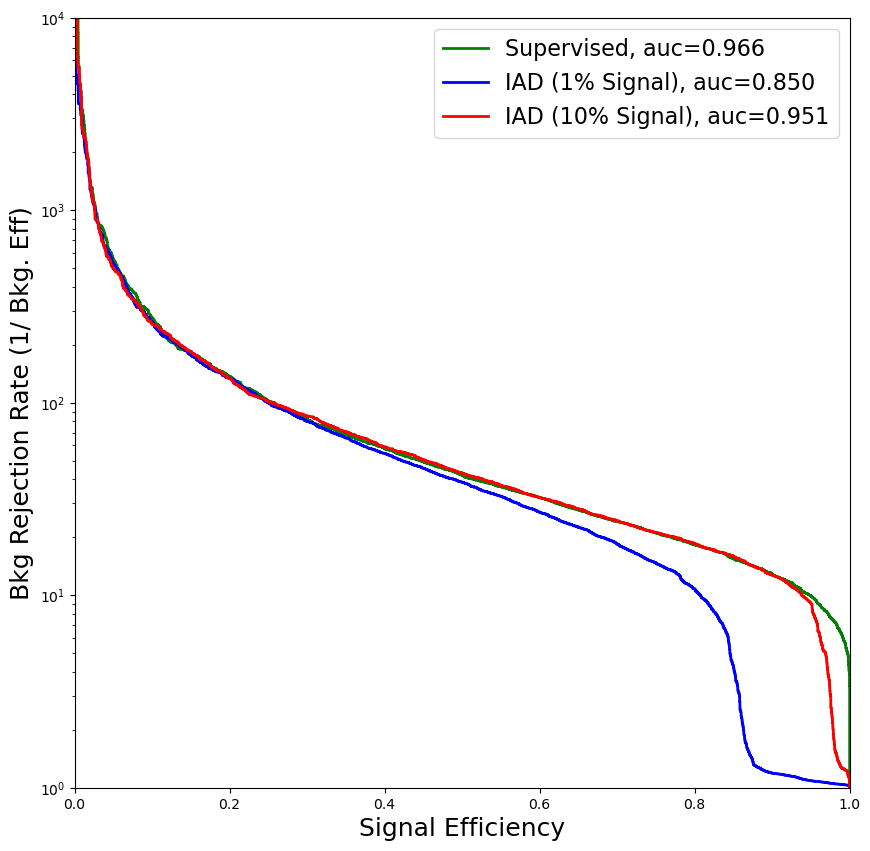

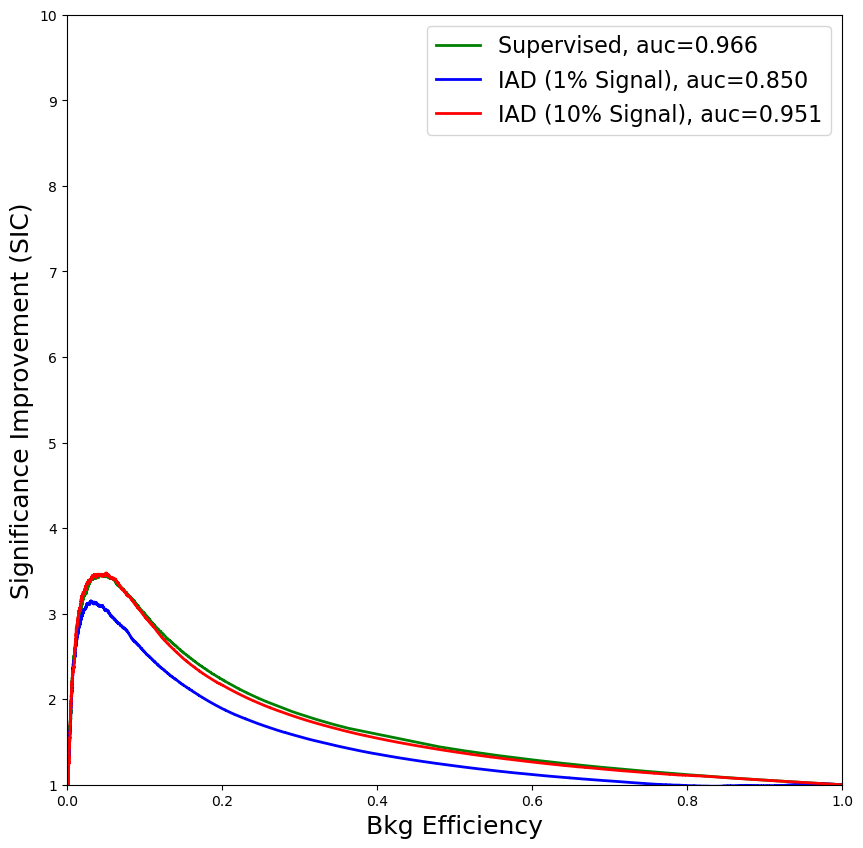

In [43]:
make_roc_plot([y_test_sup, y_test_iad1, y_test_iad2], y_test, colors = ['green', 'blue', 'red'], 
              labels = ['Supervised', 'IAD (%.0f%% Signal)' % (100.*sig_frac1), 'IAD (%.0f%% Signal)' % (100.*sig_frac2)])
plt.show()

We can see that the IAD achieves a classification performance equivalent to the supervised classifier for
the 10\% signal case. 
For the 1\% signal case the the performance is not as good, but it is still a pretty good classifier that enhances the sensisitivity by a factor of 3.
This is encouraging because for actual searches on the LHC, 1\% signal fraction is realistic to what one would expect in a realistic scenario.

Feel free to explore how the performance of anomaly detector changes as you play around with the signal fraction, change the distributions of signal and background, and change the dimensionality of the dataset.
